In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import collections
import random
import matplotlib.pyplot as plt
import numpy as np
import gym
import tqdm

In [2]:
train_env = gym.make('CartPole-v1')
test_env = gym.make('CartPole-v1')

In [3]:
SEED = 333

train_env.seed(SEED);
test_env.seed(SEED+1);
np.random.seed(SEED);
random.seed(SEED)
torch.manual_seed(SEED);

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        return x

In [5]:
input_dim = train_env.observation_space.shape[0]
hidden_dim = 32
output_dim = train_env.action_space.n

In [6]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0)

In [7]:
def train(env, policy, optimizer, discount_factor, epsilon, device):
    
    policy.train()
    
    states = []
    actions = []
    rewards = []
    next_states = []
    done = False
    episode_reward = 0

    state = env.reset()
    state = torch.FloatTensor(state).unsqueeze(0).to(device)

    while not done:

        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            q_pred = policy(state)
            action = torch.argmax(q_pred).item()
        
        next_state, reward, done, _ = env.step(action)

        next_state = torch.FloatTensor(next_state).unsqueeze(0).to(device)

        state = next_state

        episode_reward += reward

        loss = update_policy(policy, state, action, reward, next_state, discount_factor, optimizer)

    return loss, episode_reward, epsilon

In [8]:
def update_policy(policy, state, action, reward, next_state, discount_factor, optimizer):
    
    q_preds = policy(state)

    q_vals = q_preds[:, action]

    with torch.no_grad():
        q_next_preds = policy(next_state)
        q_next_vals = q_next_preds.max(1).values
        targets = reward + q_next_vals * discount_factor

    loss = F.smooth_l1_loss(targets.detach(), q_vals)
    
    optimizer.zero_grad()
    
    loss.backward()

    nn.utils.clip_grad_norm_(policy.parameters(), 0.5)

    optimizer.step()
    
    return loss.item()

In [9]:
def evaluate(env, policy, device):
    
    policy.eval()
    
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:
        
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        
        with torch.no_grad():
        
            q_pred = policy(state)
            
            action = torch.argmax(q_pred).item()

        state, reward, done, _ = env.step(action)

        episode_reward += reward

    return episode_reward

In [10]:
n_runs = 10
n_episodes = 500
discount_factor = 0.8
start_epsilon = 1.0
end_epsilon = 0.01
epsilon_decay = 0.995

train_rewards = torch.zeros(n_runs, n_episodes)
test_rewards = torch.zeros(n_runs, n_episodes)
device = torch.device('cpu')

for run in range(n_runs):
    
    policy = MLP(input_dim, hidden_dim, output_dim)
    policy = policy.to(device)
    policy.apply(init_weights)
    epsilon = start_epsilon

    optimizer = optim.RMSprop(policy.parameters(), lr=1e-6)

    for episode in tqdm.tqdm(range(n_episodes), desc=f'Run: {run}'):

        loss, train_reward, epsilon = train(train_env, policy, optimizer, discount_factor, epsilon, device)

        epsilon *= epsilon_decay
        epsilon = min(epsilon, end_epsilon)

        test_reward = evaluate(test_env, policy, device)
        
        train_rewards[run][episode] = train_reward
        test_rewards[run][episode] = test_reward

Run: 9: 100%|██████████| 500/500 [00:20<00:00, 24.69it/s]


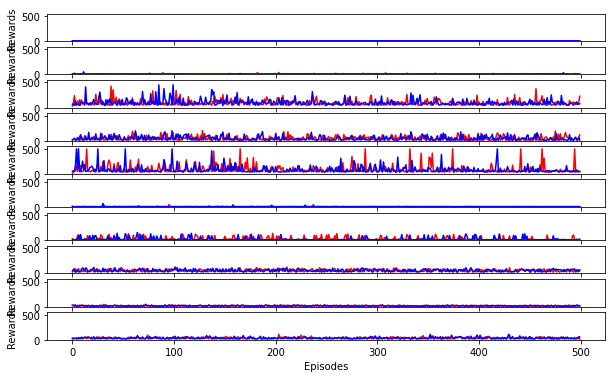

In [11]:
idxs = range(n_episodes)
fig, ax = plt.subplots(n_runs, figsize=(10,6))
for i, _ax in enumerate(ax):
    _ax.plot(idxs, train_rewards[i], c='red')
    _ax.plot(idxs, test_rewards[i], c='blue')
    _ax.set_ylim(0, 550)
    _ax.set_ylabel('Rewards');
    if i == n_runs - 1:
        _ax.set_xlabel('Episodes')

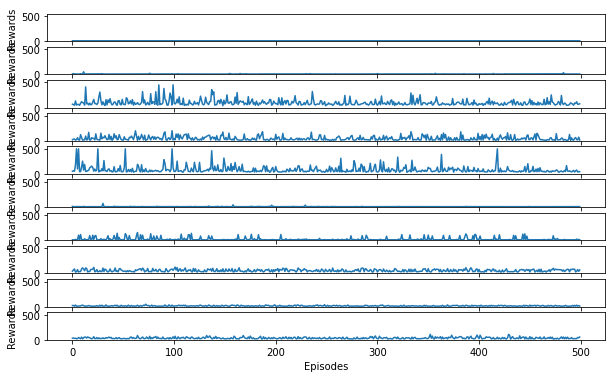

In [12]:
idxs = range(n_episodes)
fig, ax = plt.subplots(n_runs, figsize=(10,6))
for i, _ax in enumerate(ax):
    _ax.plot(idxs, test_rewards[i])
    _ax.set_ylim(0, 550)
    _ax.set_ylabel('Rewards');
    if i == n_runs - 1:
        _ax.set_xlabel('Episodes')

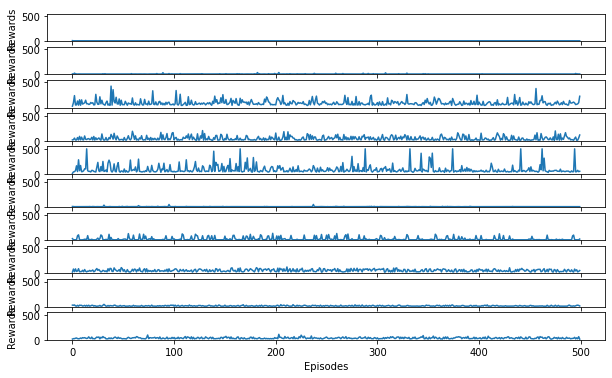

In [13]:
idxs = range(n_episodes)
fig, ax = plt.subplots(n_runs, figsize=(10,6))
for i, _ax in enumerate(ax):
    _ax.plot(idxs, train_rewards[i])
    _ax.set_ylim(0, 550)
    _ax.set_ylabel('Rewards');
    if i == n_runs - 1:
        _ax.set_xlabel('Episodes')

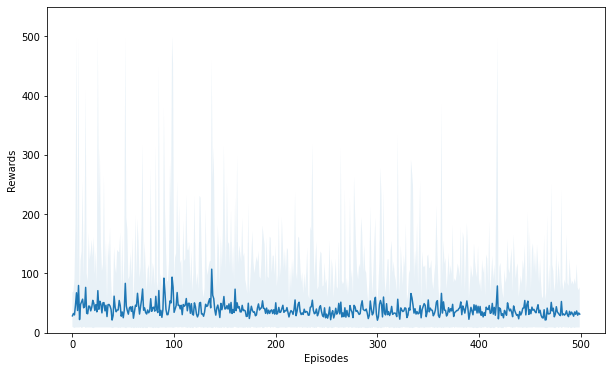

In [14]:
idxs = range(n_episodes)
fig, ax = plt.subplots(1, figsize=(10,6))
ax.plot(idxs, test_rewards.mean(0))
ax.set_ylim(0, 550)
ax.fill_between(idxs, test_rewards.min(0).values, test_rewards.max(0).values, alpha=0.1)
ax.set_xlabel('Episodes')
ax.set_ylabel('Rewards');

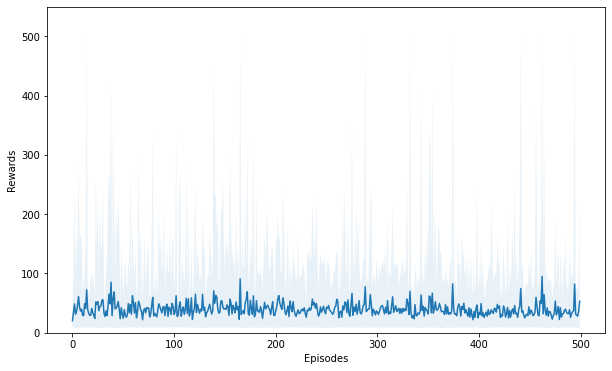

In [15]:
idxs = range(n_episodes)
fig, ax = plt.subplots(1, figsize=(10,6))
ax.plot(idxs, train_rewards.mean(0))
ax.set_ylim(0, 550)
ax.fill_between(idxs, train_rewards.min(0).values, train_rewards.max(0).values, alpha=0.1)
ax.set_xlabel('Episodes')
ax.set_ylabel('Rewards');

0.995


(0.0, 1.1)

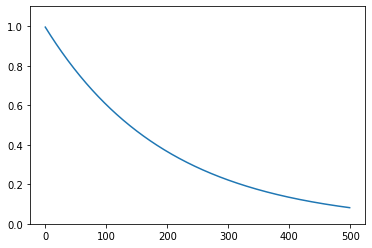

In [16]:
n = 500
start_x = 1.0
decay = 0.995
print(decay)
min_x = 0.01
x = start_x
ys = []
for i in range(n):
    x *= decay
    x = max(x, min_x)
    ys.append(x)
plt.plot(ys)
plt.ylim(0,1.1)

In [17]:
np.e

2.718281828459045

In [18]:
q = collections.deque(maxlen=5)

In [19]:
q

deque([])

In [20]:
len(q)

0

In [21]:
q.append(1)

In [22]:
20_000/500

40.0

In [23]:
q.maxlen

5

In [24]:
q.append(1)
q.append(1)
q.append(1)
q.append(1)

In [25]:
len(q)

5

In [26]:
q.append(1)
q.append(1)
q.append(1)
q.append(1)

In [27]:
q

deque([1, 1, 1, 1, 1])

In [28]:
len(q)

5